#3. KNN Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.model_selection import KFold
import pydotplus
from sklearn import tree
from sklearn.metrics import r2_score
import seaborn as sns
import pickle as pkl
import math
import matplotlib.pyplot as plt
import time
import platform
import random
import os

In this problem you are required to train, test and validate a K-Nearest Neighbor Classifier on the famous CIFAR-10 dataset. The next few cells will guide you through the process. Follow along...

In [ ]:
# Download the dataset
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2021-02-09 14:01:30--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  46.3MB/s    in 3.9s    

2021-02-09 14:01:34 (41.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pkl.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
  
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

cifar10_dir = 'cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

#from google.colab import drive
#drive.mount('/content/drive')

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


####Next we visualize the CIFAR-10 dataset. Although these functions are being written for you, we highly recommend you go through the code and make yourself familiar as these are things you will be required to do very often when working on AI/ML projects

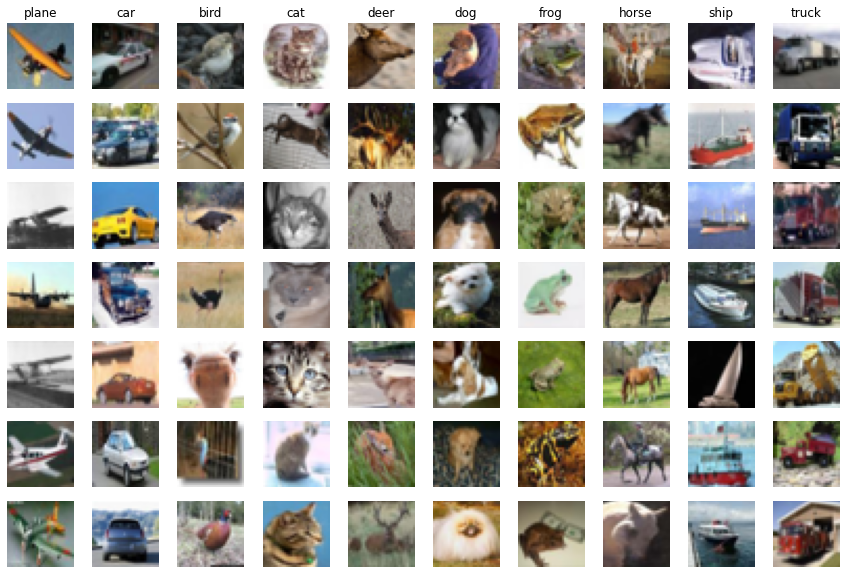

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

####In the next cell we flatten each image into a single dimensional vector so that it is easy to process. You should be able to reason about the dimensions comfortable.

In [ ]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


####In the next cell you are going to implement the main KNearestNeighbor class and keep adding functions to it as and when required in the subsequent steps.

In [ ]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    xtrain = []
    ytrain = []


    def __init__(self):
        pass


    def L2_distance(self, datapoint1, datapoint2):
        temp = datapoint1-datapoint2
        temp=temp.dot(temp)
        return math.sqrt(temp)


    def compute_distances(self, test_img):
        distances = []
        for i in range (0,len(self.xtrain)):

            dist = self.L2_distance(test_img, self.xtrain[i])
            distances.append(dist)
        return distances


    def compute_distances_one_loop(self, X_test):
      num_test = len(X_test)
      num_train = self.xtrain.shape[0]
      distances = np.zeros((num_test, num_train))
      for i in range(num_test):
          distances[i, :] = np.sum((self.xtrain - X_test[i, :])**2, axis=1)
      return distances


    def compute_distances_no_loop(self,X_test):
      num_test = len(X_test)
      num_train = self.xtrain.shape[0]
      distances = np.zeros((num_test, num_train))
      distances = np.sqrt((X_test**2).sum(axis=1)[:, np.newaxis] + (self.xtrain**2).sum(axis=1) - 2 * X_test.dot(self.xtrain.T))
      return distances


    def compute_distances_two_loops(self, X_test):
        distances = []
        for test_img in X_test: 
            dist = self.compute_distances(test_img)
            distances.append(dist)
        return np.array(distances)


    def train(self, X_train, y_train):
        self.xtrain = X_train
        self.ytrain = y_train.reshape(-1,1)


    def findMode(self, k_nearest):
        freq = {}
        for i in range (len(k_nearest)):
            item = k_nearest[i][0]
            if item in freq:
                freq[item] += 1
            else:
                freq[item] = 1
        mode = 0
        fr = 0
        for key in freq:
            if freq[key] > fr:
                fr = freq[key]
                mode = key
        return mode


    def helper(self, distances, k):
        rows = []

        for i in range(0, len(distances)):
            temp = []
            temp.append(distances[i])
            temp.append(self.ytrain[i])
            rows.append(temp)

        rows.sort(key = lambda x:x[0])
  
        k_nearest = []
        for i in range(0, k):
            k_nearest.append(rows[i][1])

        return self.findMode(k_nearest)


    def predict_labels(self, dists, k):
        y_test_pred = []
        dists = list(dists)

        for i in dists:
            pred = self.helper(i, k)
            y_test_pred.append(pred)
        return y_test_pred
        
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

####Now we have a basic classifier ready but it is extremely inefficient. In Machine Learning writing vectorised code is one of the most important skills.

####Now you have to again go back to the KNearestNeighbor class cell and add functions to compute the distance matrix using:

*   Single loop
*   No loops

####From here onwards we won't do as much hand holding as done before. You are expected to write all the code from scratch

In [ ]:
print("\nTime Calculation")
print("--------------------------------------")
print()

st = time.time()
dists1 = classifier.compute_distances_two_loops(X_test)
print("Time taken using two loops : ", time.time()-st)

st = time.time()
dists2 = classifier.compute_distances_one_loop(X_test)
print("Time taken using one loop : ", time.time()-st)

st = time.time()
dists3 = classifier.compute_distances_no_loop(X_test)
print("Time taken using zero loop : ", time.time()-st)


Time Calculation
--------------------------------------

Time taken using two loops :  13.20035696029663
Time taken using one loop :  26.423075675964355
Time taken using zero loop :  0.46537208557128906


####Next, you are required to tabulate the time taken to compute the distance matrix using each of the three above methods implemented for k = 1, 3, 5, 7.

In [ ]:
y_predicts = []

K = [1,3,5,7]

for k in K:
    y_test_pred = classifier.predict_labels(dists1,k)
    y_predicts.append(y_test_pred)

print("\nAccuracy for different values of k")
print("--------------------------------------")
print()

for i in range(4):
    crrct_pred = 0
    for idx in range(len(y_test)):
        if y_predicts[i][idx] == y_test[idx]:
            crrct_pred += 1

    accuracy = float(crrct_pred) / len(y_test)
    print("K = " + str (K[i]) + " : ", end = "")
    print('%d / %d correct => accuracy: %f' % (crrct_pred, len(y_test), accuracy))


Accuracy for different values of k
--------------------------------------

K = 1 : 137 / 500 correct => accuracy: 0.274000
K = 3 : 140 / 500 correct => accuracy: 0.280000
K = 5 : 145 / 500 correct => accuracy: 0.290000
K = 7 : 146 / 500 correct => accuracy: 0.292000


As you can see that in KNN algorithm it is important to tune the hyperparameter K. We will do this using Cross Validation Leave One Out approach. The idea is to split the train set into few folds(here we recommend you to set the fold number to 5). Then, for each value of K, we leave one of these folds out to evaluate performance but use the others to train. Repeat this by leaving each fold out once. You will get 5 accuracies in this case, one for leaving out each fold. Depending on the average accuracy decide on the optimal value of K. Report the same. We also expect you to present plots showing the average accuracy and standard deviation for each value of K.

### Cross validation

In [ ]:
splitted_x_train = np.array_split(X_train,5)
splitted_y_train = np.array_split(y_train,5)

for k in K:

    print("\n\nRunning for K = " + str(k))
    print('------------------------------------')
    print()

    acry = []

    for i in range(len(splitted_x_train)):
        xtrain = []
        ytrain = []
        xtest = []
        ytest = []

        for j in range(len(splitted_x_train)):
            
            if i!=j:
                xtrain.extend(splitted_x_train[j])
                ytrain.extend(splitted_y_train[j])

            else:
                xtest.extend(splitted_x_train[j])
                ytest.extend(splitted_y_train[j])

        xtrain = np.array(xtrain)
        xtest = np.array(xtest)
        ytrain = np.array(ytrain)
        ytest = np.array(ytest)

        classifier = KNearestNeighbor()
        classifier.train(xtrain, ytrain)
        distances = classifier.compute_distances_no_loop(xtest)
        y_test_pred = classifier.predict_labels(distances,k)

        crrct_pred = 0
        for idx in range(len(ytest)):
            if y_test_pred[idx] == ytest[idx]:
                crrct_pred += 1 

        accuracy = float(crrct_pred) / len(ytest)
        print("Fold " + str (i+1) + " : ", end = "")
        print('%d / %d correct => accuracy: %f' % (crrct_pred, len(ytest), accuracy))
        acry.append(accuracy)

    sum = 0.0
    for acr in acry:
        sum += acr
    
    avg_acry = sum/5.0

    print("\nAverage Accuracy for K = " + str(k) + " is : " + str (avg_acry))




Running for K = 1
------------------------------------

Fold 1 : 263 / 1000 correct => accuracy: 0.263000
Fold 2 : 257 / 1000 correct => accuracy: 0.257000
Fold 3 : 264 / 1000 correct => accuracy: 0.264000
Fold 4 : 278 / 1000 correct => accuracy: 0.278000
Fold 5 : 266 / 1000 correct => accuracy: 0.266000

Average Accuracy for K = 1 is : 0.2656


Running for K = 3
------------------------------------

Fold 1 : 257 / 1000 correct => accuracy: 0.257000
Fold 2 : 263 / 1000 correct => accuracy: 0.263000
Fold 3 : 273 / 1000 correct => accuracy: 0.273000
Fold 4 : 282 / 1000 correct => accuracy: 0.282000
Fold 5 : 270 / 1000 correct => accuracy: 0.270000

Average Accuracy for K = 3 is : 0.269


Running for K = 5
------------------------------------

Fold 1 : 265 / 1000 correct => accuracy: 0.265000
Fold 2 : 275 / 1000 correct => accuracy: 0.275000
Fold 3 : 295 / 1000 correct => accuracy: 0.295000
Fold 4 : 298 / 1000 correct => accuracy: 0.298000
Fold 5 : 284 / 1000 correct => accuracy: 0.2840


---


